# pseudo label using Random Forest and majority voting

## preprocessing data (normalisasi)

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ========= CONFIG =========
IN_CSV  = "final.csv"             # data baru
OUT_CSV = "final_normalized.csv"  # hasil

# ========= LOAD ===========
df = pd.read_csv(IN_CSV)

# ========= COLUMNS =========
scale_cols = ["mention_count", "word_count"]      # hanya dua ini dinormalisasi
bool_col   = "is_primary_in_sentence"             # disimpan sebagai boolean

# -- pastikan tipe --
for col in scale_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# kolom boolean → True/False
df[bool_col] = df[bool_col].astype(bool)

# ========= MIN-MAX NORMALIZATION (0-1) =========
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# ========= SAVE =================================
df.to_csv(OUT_CSV, index=False)
print(f"✅  mention_count & word_count ternormalisasi; '{bool_col}' tetap boolean ➜ {OUT_CSV}")


✅  mention_count & word_count ternormalisasi; 'is_primary_in_sentence' tetap boolean ➜ final_normalized.csv


## pseudo labelling

In [1]:
"""
label_final_normalized.py
-------------------------
• Memuat Random-Forest terbaik + artefak TF-IDF & LabelEncoder  
• Memprediksi label `type` untuk `final_normalized.csv`  
• Menambahkan kolom probabilitas dan menyimpan ke `final_labeled.csv`
"""

import os, joblib, pandas as pd
from scipy.sparse import hstack

# ═════ PATHS ════════════════════════════════════════════════════════
ROOT_DIR      = "random_forest_model/random_forest_normalized"                # folder model
BEST_MODEL    = os.path.join(ROOT_DIR, "best_model.pkl")
TFIDF_VEC     = os.path.join(ROOT_DIR, "tfidf.pkl")
LBL_ENCOD     = os.path.join(ROOT_DIR, "label_encoder.pkl")

DATA_IN       = "final_normalized.csv"     # sudah dinormalisasi
DATA_OUT      = "final_labeled.csv"        # hasil berlabel

# ═════ LOAD ARTEFAK MODEL ═══════════════════════════════════════════
rf    = joblib.load(BEST_MODEL)
tfidf = joblib.load(TFIDF_VEC)
le    = joblib.load(LBL_ENCOD)

# ═════ LOAD & PREPARE DATA BARU ═════════════════════════════════════
df = pd.read_csv(DATA_IN)

# pastikan kolom numerik dalam float (bool→float utk hstack)
num_cols = ["mention_count", "word_count", "is_primary_in_sentence"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(float)

X_num  = df[num_cols].values
X_text = tfidf.transform(df["text"].fillna(""))
X      = hstack([X_num, X_text])

# ═════ PREDICT  ═════════════════════════════════════════════════════
y_pred = rf.predict(X)
probs  = rf.predict_proba(X)

df["predicted_type"] = le.inverse_transform(y_pred)
for idx, cls in enumerate(le.classes_):
    df[f"conf_{cls}"] = probs[:, idx]

# ═════ SAVE  ════════════════════════════════════════════════════════
df.to_csv(DATA_OUT, index=False)
print(f"✅  File berlabel disimpan ➜ {DATA_OUT}")


✅  File berlabel disimpan ➜ final_labeled.csv


In [1]:
"""
label_final_normalized.py
-------------------------
• Muat Random-Forest terbaik + artefak TF-IDF & LabelEncoder
• Prediksi `predicted_type` untuk `final_normalized.csv`
• Tambah probabilitas & URUTKAN kolom sesuai permintaan
• Simpan ke `final_labeled_ordered.csv`
"""

import os, joblib, pandas as pd
from scipy.sparse import hstack

# ── PATHS ───────────────────────────────────────────────────────────
ROOT_DIR   = "random_forest_model/random_forest_normalized"
BEST_MODEL = os.path.join(ROOT_DIR, "best_model.pkl")
TFIDF_VEC  = os.path.join(ROOT_DIR, "tfidf.pkl")
LBL_ENCOD  = os.path.join(ROOT_DIR, "label_encoder.pkl")

DATA_IN    = "final_normalized.csv"
DATA_OUT   = "final_labeled_ordered.csv"

# ── LOAD ARTEFAK MODEL ─────────────────────────────────────────────
rf    = joblib.load(BEST_MODEL)
tfidf = joblib.load(TFIDF_VEC)
le    = joblib.load(LBL_ENCOD)

# ── LOAD & PREP DATA ───────────────────────────────────────────────
df = pd.read_csv(DATA_IN)

num_cols = ["mention_count", "word_count", "is_primary_in_sentence"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(float)

X_num  = df[num_cols].values
X_text = tfidf.transform(df["text"].fillna(""))
X      = hstack([X_num, X_text])

# ── PREDICT ────────────────────────────────────────────────────────
y_pred = rf.predict(X)
probs  = rf.predict_proba(X)

df["predicted_type"] = le.inverse_transform(y_pred)
for idx, cls in enumerate(le.classes_):
    df[f"conf_{cls}"] = probs[:, idx]

# ── RE-ORDER COLUMNS ───────────────────────────────────────────────
desired_order = [
    "story_id", "person", "aliases",
    "predicted_type",
    "sentence_id", "text", "mention_count", "word_count",
    "text_prev", "text_next", "bert_context",
    "is_primary_in_sentence",
    "conf_antagonist", "conf_others", "conf_protagonist"
]

missing = [c for c in desired_order if c not in df.columns]
if missing:
    raise ValueError(f"Kolom hilang di DataFrame: {missing}")

df = df[desired_order]

# ── SAVE ───────────────────────────────────────────────────────────
df.to_csv(DATA_OUT, index=False)
print(f"✅  File berlabel & terurut tersimpan ➜ {DATA_OUT}")


✅  File berlabel & terurut tersimpan ➜ final_labeled_ordered.csv


## applying majority vote

In [ ]:
"""
majority_vote_custom_final.py   (no-fail version)
-------------------------------------------------
Output ➜ majority/final_predicted_majority_sorted_custom.csv
• ≥1 protagonist per story (hard guarantee)
• Antagonist bersyarat (confidence / mention)
• Sisanya others
"""

import os
import pandas as pd

# ── PATH & PARAMS ───────────────────────────────────────────────────
IN_CSV  = "final_labeled_ordered.csv"
OUT_CSV = "majority/final_predicted_majority_sorted_custom.csv"

THR_ANT    = 0.40   # rata2 confidence antagonist
REL_THRESH = 0.20   # 20 % dari max mention_total

# ── LOAD ────────────────────────────────────────────────────────────
df = pd.read_csv(IN_CSV)

# ── 1. Statistik tokoh ─────────────────────────────────────────────
agg = (
    df.groupby(["story_id", "person"]).agg(
        pro_cnt        = ("predicted_type", lambda s: (s == "protagonist").sum()),
        ant_cnt        = ("predicted_type", lambda s: (s == "antagonist").sum()),
        oth_cnt        = ("predicted_type", lambda s: (s == "others").sum()),
        pro_conf_total = ("conf_protagonist", "sum"),
        ant_conf_total = ("conf_antagonist",  "sum"),
        mention_total  = ("mention_count",    "sum"),
    )
    .reset_index()
)

def majority(row):
    if row.pro_cnt == 0 and row.ant_cnt == 0:
        return "others"
    return max(
        {"protagonist": row.pro_cnt, "antagonist": row.ant_cnt, "others": row.oth_cnt},
        key=lambda k: {"protagonist": row.pro_cnt,
                       "antagonist" : row.ant_cnt,
                       "others"     : row.oth_cnt}[k],
    )

agg["label"] = agg.apply(majority, axis=1)

def choose(sub, sort_cols, asc):
    """Pick index of best candidate; sort_cols & asc list same len."""
    return sub.sort_values(sort_cols, ascending=asc).index[0]

# ── 2 – 4. Per-story logika utama ───────────────────────────────────
for sid, idx in agg.groupby("story_id").groups.items():
    sub = agg.loc[idx]

    # 2️⃣  Protagonist wajib (bukti kalimat / mention terbesar)
    if (sub.label == "protagonist").sum() == 0:
        pro_cand = sub[sub.pro_cnt > 0]
        cand = choose(pro_cand, ["pro_cnt", "pro_conf_total", "mention_total"], asc=[False]*3) \
               if not pro_cand.empty else choose(sub, ["mention_total"], asc=[False])
        agg.loc[cand, "label"] = "protagonist"

    # 3️⃣  Antagonist berbukti (kalimat)
    sub = agg.loc[idx]
    if (sub.label == "antagonist").sum() == 0:
        ant_cand = sub[sub.ant_cnt > 0]
        if not ant_cand.empty:
            cand = choose(ant_cand,
                          ["ant_cnt", "ant_conf_total", "mention_total"],
                          asc=[False]*3)
            agg.loc[cand, "label"] = "antagonist"

    # 4️⃣  Tambahan antagonist via confidence / mention
    sub = agg.loc[idx]
    if (sub.label == "antagonist").sum() == 0:
        others = sub[sub.label == "others"].copy()
        others["ant_conf_avg"] = others.ant_conf_total / others.oth_cnt.clip(lower=1)
        cand_conf = others[others.ant_conf_avg >= THR_ANT]
        if not cand_conf.empty:
            cand = choose(cand_conf,
                          ["ant_conf_avg", "ant_conf_total", "mention_total"],
                          asc=[False]*3)
            agg.loc[cand, "label"] = "antagonist"

    # 5️⃣  SANITY: jika masih tak ada protagonist → paksa mention tertinggi
    sub = agg.loc[idx]
    if (sub.label == "protagonist").sum() == 0:
        cand = choose(sub, ["mention_total"], asc=[False])
        agg.loc[cand, "label"] = "protagonist"

    # 6️⃣  Fallback antagonist via relatif mention_total
    sub = agg.loc[idx]
    if (sub.label == "antagonist").sum() == 0:
        max_m = sub.mention_total.max()
        cand_sub = sub[(sub.label == "others") &
                       (sub.mention_total >= REL_THRESH * max_m)]
        if not cand_sub.empty:
            cand = choose(cand_sub,
                          ["pro_conf_total", "mention_total"],
                          asc=[True, False])
            agg.loc[cand, "label"] = "antagonist"

# ── 5. Sort & save ─────────────────────────────────────────────────
agg["person_num"] = agg["person"].str.extract(r"Tokoh-(\d+)", expand=False).astype(int)
final_df = (
    agg.sort_values(["story_id", "person_num"])
        .rename(columns={"label": "predicted_type"})
        .drop(columns="person_num")
        .reset_index(drop=True)
)

os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
final_df.to_csv(OUT_CSV, index=False)
print("✅  Final file disimpan (tiap story ≥1 protagonist).")


✅  Final file disimpan (tiap story ≥1 protagonist).


In [2]:
import pandas as pd

# === PATH ke file majority-vote karakter ===
csv_path = "majority/final_predicted_majority_sorted_custom.csv"

# === LOAD data ===
df = pd.read_csv(csv_path)

# === HITUNG jumlah tipe per story (wide format) ============
summary = (
    df.groupby(["story_id", "predicted_type"])
      .size()
      .unstack(fill_value=0)                  # kolom = label
      .reindex(columns=["protagonist",
                        "antagonist",
                        "others"],            # urutan kolom
               fill_value=0)
      .reset_index()
)

# === SIMPAN & CETAK ========================================
out_path = "majority/story_type_summary.csv"
summary.to_csv(out_path, index=False)

print("📊 Ringkasan jumlah karakter per story:")
print(summary.head())
print(f"\n✅  Tabel lengkap disimpan di '{out_path}'")


📊 Ringkasan jumlah karakter per story:
predicted_type  story_id  protagonist  antagonist  others
0                      1            1           1       6
1                      2            2           1       6
2                      3            1           0      12
3                      4            4           0       8
4                      5            2           0       3

✅  Tabel lengkap disimpan di 'majority/story_type_summary.csv'


In [3]:
import pandas as pd

# === PATH ke hasil majority-vote yg sudah difiksasi ===
csv_path = "majority/final_predicted_majority_sorted_custom.csv"

# === LOAD ===
df = pd.read_csv(csv_path)

# === REKAP jumlah label per story (wide) ===============
summary = (
    df.groupby(["story_id", "predicted_type"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=["protagonist", "antagonist", "others"], fill_value=0)
      .reset_index()
)

# === CARI story yang protagonist-nya 0 ==================
no_prota = summary[summary["protagonist"] == 0]

print("\n🔍 Story tanpa protagonist sama sekali:")
print(no_prota if not no_prota.empty else "Semua story sudah punya ≥1 protagonist")

# (opsional) simpan kedua tabel
summary.to_csv("majority/story_type_summary.csv", index=False)
no_prota.to_csv("majority/story_without_protagonist.csv", index=False)

print("\n✅  Rekap lengkap ➜ majority/story_type_summary.csv")
if not no_prota.empty:
    print("⚠️  Story tanpa protagonist ➜ majority/story_without_protagonist.csv")



🔍 Story tanpa protagonist sama sekali:
Semua story sudah punya ≥1 protagonist

✅  Rekap lengkap ➜ majority/story_type_summary.csv


In [4]:
import pandas as pd

# === PATH ke file majority-vote (karakter) ===
csv_path = "majority/final_predicted_majority_sorted_custom.csv"

# === LOAD ===
df = pd.read_csv(csv_path)

# === HITUNG TOTAL FREKUENSI SETIAP LABEL =========================
type_counts = df["predicted_type"].value_counts().reindex(
    ["protagonist", "antagonist", "others"], fill_value=0
)

print("🔢 Total karakter per label:")
print(type_counts)

🔢 Total karakter per label:
predicted_type
protagonist     480
antagonist      188
others         1536
Name: count, dtype: int64


## final csv labelled

In [5]:
import pandas as pd

# === PATH file majority final ===
IN_CSV  = "majority/final_predicted_majority_sorted_custom.csv"
OUT_CSV = "majority/final_predicted_majority_minimal.csv"

# === LOAD & PILIH 3 KOLOM SAJA ===============================
cols_to_keep = ["story_id", "person", "predicted_type"]
df = pd.read_csv(IN_CSV, usecols=cols_to_keep)

# === SAVE ULANG =============================================
df.to_csv(OUT_CSV, index=False)
print(f"✅  Disimpan ke '{OUT_CSV}' hanya dengan kolom:", ", ".join(cols_to_keep))


✅  Disimpan ke 'majority/final_predicted_majority_minimal.csv' hanya dengan kolom: story_id, person, predicted_type


In [ ]:
import pandas as pd

# ── PATHS ───────────────────────────────────────────────────────────
MIN_CSV   = "majority/final_predicted_majority_minimal.csv"  # 3-kolom (story_id, person, predicted_type)
NORM_CSV  = "final_normalized.csv"                           # sentence-level data
OUT_CSV   = "final_normalized_labeled.csv"                   # hasil gabung

# ── 1. LOAD dataset ────────────────────────────────────────────────
df_min  = pd.read_csv(MIN_CSV)      # story_id | person | predicted_type
df_norm = pd.read_csv(NORM_CSV)     # sentence-level tanpa predicted_type

# ── 2. MERGE berdasarkan story_id + person ─────────────────────────
df_merge = (
    df_norm.merge(df_min, on=["story_id", "person"], how="left")
            .copy()
)

# ── 3. URUTAN kolom sesuai permintaan ─────────────────────────────
desired_order = [
    "story_id", "person", "aliases",
    "predicted_type",
    "sentence_id", "text", "mention_count", "word_count",
    "text_prev", "text_next", "bert_context",
    "is_primary_in_sentence"
]

df_merge = df_merge[desired_order]

# ── 4. SAVE ────────────────────────────────────────────────────────
df_merge.to_csv(OUT_CSV, index=False)
print(f"✅  File gabungan disimpan ➜ {OUT_CSV}")


✅  File gabungan disimpan ➜ final_normalized_labeled.csv


## final labelled

In [2]:
import os
import pandas as pd

# 1. Definisikan peta (mapping) dari label bahasa Inggris → bahasa Indonesia
label_map = {
    "others":       "Lainnya",
    "protagonist":  "Protagonis",
    "antagonist":   "Antagonis"
}

# 2. Tentukan nama folder output baru
output_dir = "final_majority"
os.makedirs(output_dir, exist_ok=True)

# 3. Baca file CSV yang sudah berisi prediksi dalam bahasa Inggris
infile = "majority/final_predicted_majority_minimal.csv"
df = pd.read_csv(infile)

# 4. Ganti isi kolom 'predicted_type' menggunakan mapping
df["predicted_type"] = df["predicted_type"].map(label_map)

# 5. Simpan kembali ke CSV baru di dalam folder “renamed/”
outfile = os.path.join(output_dir, "final_predicted_majority_minimal_indo.csv")
df.to_csv(outfile, index=False, encoding="utf-8")

print(f"File berhasil disimpan di: {outfile}")


File berhasil disimpan di: final_majority\final_predicted_majority_minimal_indo.csv


In [1]:
import pandas as pd
import os

# === File Paths ===
majority_path = "majority/final_predicted_majority_minimal.csv"
normalized_path = "final_normalized_labeled.csv"
output_path = "final_majority/final_predicted_with_aliases.csv"

# === Load CSVs ===
majority_df = pd.read_csv(majority_path)
normalized_df = pd.read_csv(normalized_path)

# === Convert stringified list of aliases to actual list ===
normalized_df["aliases"] = normalized_df["aliases"].apply(eval)

# === Group aliases by story_id and person, combine unique aliases into a flattened list ===
aliases_df = (
    normalized_df.groupby(["story_id", "person"])["aliases"]
    .apply(lambda lists: sorted(set(alias for sublist in lists for alias in sublist)))
    .reset_index()
)

# === Merge with majority prediction ===
merged_df = pd.merge(majority_df, aliases_df, on=["story_id", "person"], how="left")

# === Reorder and format columns ===
merged_df["aliases"] = merged_df["aliases"].apply(lambda x: ", ".join(x))
final_df = merged_df[["story_id", "person", "aliases", "predicted_type"]]

# === Create output folder if needed ===
os.makedirs("final_majority", exist_ok=True)

# === Save final result ===
final_df.to_csv(output_path, index=False)
print(f"✅ File saved to {output_path}")


✅ File saved to final_majority/final_predicted_with_aliases.csv


In [2]:
import pandas as pd

# === Load the previously created file ===
input_path = "final_majority/final_predicted_with_aliases.csv"
output_path = "final_majority/final_predicted_with_aliases_indo.csv"

# === Load file ===
df = pd.read_csv(input_path)

# === Rename predicted_type values ===
translation_map = {
    "protagonist": "protagonis",
    "antagonist": "antagonis",
    "others": "lainnya"
}
df["predicted_type"] = df["predicted_type"].map(translation_map)

# === Save updated file ===
df.to_csv(output_path, index=False)
print(f"✅ File saved to {output_path} with translated predicted_type labels.")


✅ File saved to final_majority/final_predicted_with_aliases_indo.csv with translated predicted_type labels.


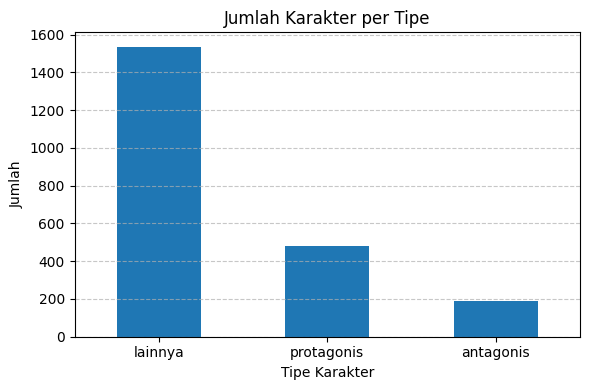

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load the CSV ===
df = pd.read_csv("final_majority/final_predicted_with_aliases_indo.csv")

# === Count character types ===
type_counts = df["predicted_type"].value_counts()

# === Plot ===
plt.figure(figsize=(6, 4))
type_counts.plot(kind="bar")

plt.title("Jumlah Karakter per Tipe")
plt.xlabel("Tipe Karakter")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


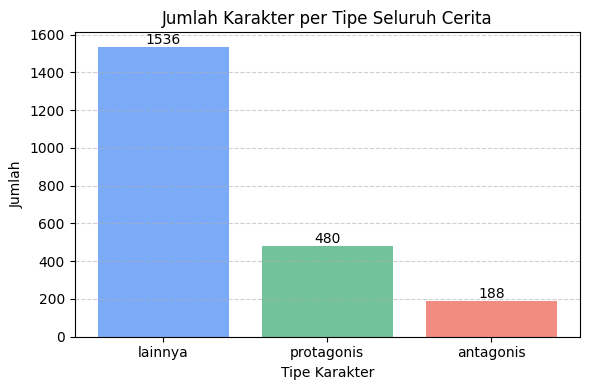

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load the CSV ===
df = pd.read_csv("final_majority/final_predicted_with_aliases_indo.csv")

# === Count character types ===
type_counts = df["predicted_type"].value_counts()

# === Medium-soft color mapping (not too pale, not too bold) ===
colors = {
    "protagonis": "#72C29B",   # medium-soft green
    "antagonis": "#F28B82",    # medium-soft red
    "lainnya": "#7BAAF7"       # medium-soft blue
}

# === Create the bar plot ===
plt.figure(figsize=(6, 4))
bars = plt.bar(type_counts.index, type_counts.values, color=[colors[t] for t in type_counts.index])

# === Add value labels above each bar ===
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.title("Jumlah Karakter per Tipe Seluruh Cerita")
plt.xlabel("Tipe Karakter")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


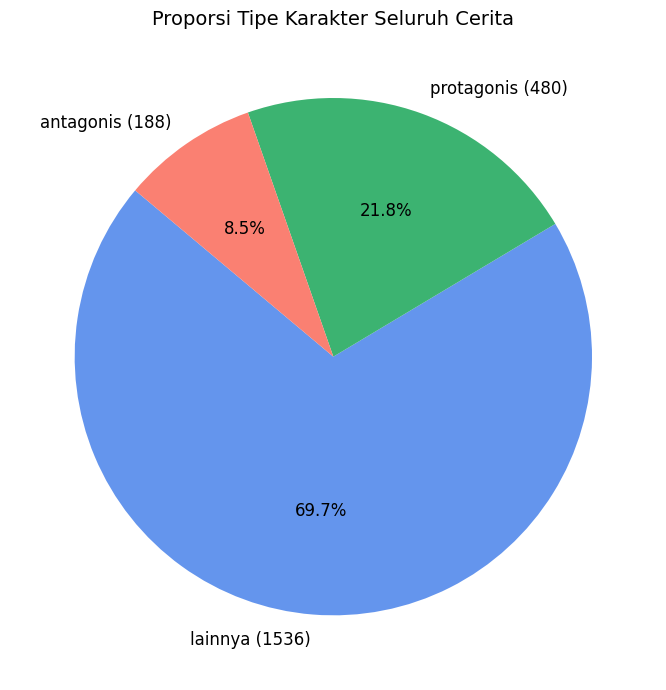

In [11]:
import matplotlib.pyplot as plt

# Data
labels = ['lainnya', 'protagonis', 'antagonis']
sizes = [1536, 480, 188]
colors = ['cornflowerblue', 'mediumseagreen', 'salmon']

# Buat label dengan angka
custom_labels = [f'{label} ({size})' for label, size in zip(labels, sizes)]

# Pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=custom_labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proporsi Tipe Karakter Seluruh Cerita', fontsize=14)
plt.tight_layout()
plt.show()


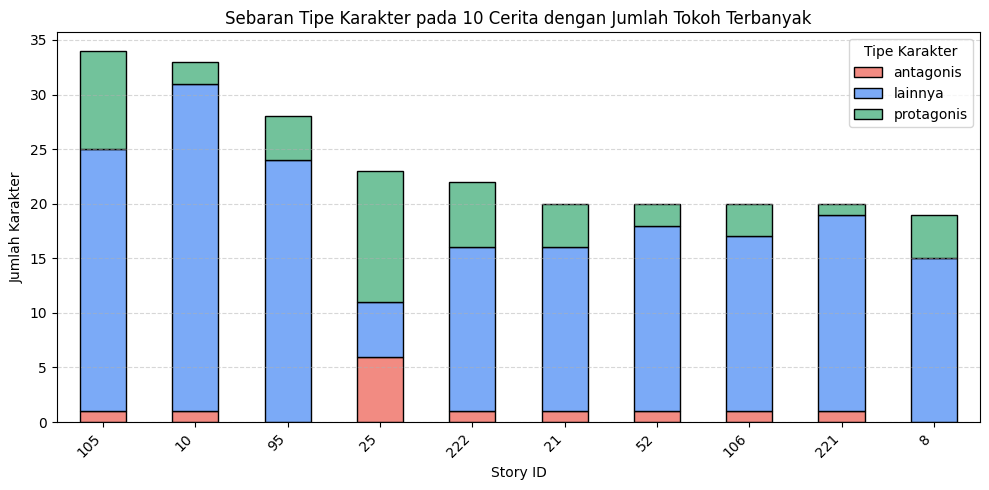

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("final_majority/final_predicted_with_aliases_indo.csv")

# Hitung jumlah karakter per story_id dan tipe
grouped = df.groupby(["story_id", "predicted_type"]).size().unstack(fill_value=0)

# Hitung total karakter per cerita dan ambil top 10
top10_stories = grouped.sum(axis=1).nlargest(10).index
top10_data = grouped.loc[top10_stories]

# Warna
colors = {
    "protagonis": "#72C29B",
    "antagonis": "#F28B82",
    "lainnya": "#7BAAF7"
}

# Plot
top10_data.plot(kind="bar", stacked=True,
                color=[colors.get(col, "#ccc") for col in top10_data.columns],
                figsize=(10, 5), edgecolor="black")

plt.title("Sebaran Tipe Karakter pada 10 Cerita dengan Jumlah Tokoh Terbanyak")
plt.xlabel("Story ID")
plt.ylabel("Jumlah Karakter")
plt.legend(title="Tipe Karakter")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()
